In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "7"

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from medpy import io
import six
import pandas as pd
import SimpleITK as sitk
import seaborn as sns
from sklearn.metrics import roc_auc_score
import math

import torch
from torch import optim, nn, utils, Tensor
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
import lightning.pytorch as pl
from torchsummary import summary
import torch.nn.functional as F

import monai
from monai.networks.nets import resnet10, resnet18, resnet50

from torch.utils.data import DataLoader

/u/home/seel/.conda/envs/conda-adlm/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.device(0))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

True
1
0
Using device: cuda

NVIDIA A40
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [4]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../')
from data_scripts.PI_CAI_Detection import PI_CAI_Detection
#from models.MedNet import resnet10, resnet18, resnet50

In [14]:
labels_path='/data1/practical-sose23/morphometric/picai_labels'
image_path='/data1/practical-sose23/morphometric/data'
modalities=["t2w"]
targetVoxelShape= (1.0, 1.0, 3.0) #(0.5, 0.5, 3.0)#(1,1,1) #EXP1: STUPID RESULTS
targetimageSize = [220, 220, 45]#(500,500,50)
multiModel=False
useAI_Segmentation=False
biasFeildCorrection=False
toShuffle = False
batchSize = 10

dataset = PI_CAI_Detection(image_path,labels_path,modalities,\
                            multiModel,useAI_Segmentation,biasFeildCorrection,\
                            targetVoxelShape,targetimageSize)

#train_Lables=[]
#for _,_,batch_labels in loader:
#    train_Lables.extend(batch_labels)

#class_sample_count = np.unique(train_Lables, return_counts=True)[1]
#weight = 1. / class_sample_count
#samples_weight = weight[train_Lables]
#WeightedRandomSampler = utils.data.sampler.WeightedRandomSampler(samples_weight, len(samples_weight))

generator1 = torch.Generator().manual_seed(42)
train, val, test = utils.data.random_split(dataset, [0.6, 0.2, 0.2], generator=generator1)



train_loader = DataLoader(train,batch_size=batchSize,shuffle=toShuffle, num_workers=10)#, sampler=WeightedRandomSampler)
val_loader = DataLoader(val,batch_size=batchSize,shuffle=toShuffle, num_workers=4)
test_loader = DataLoader(test,batch_size=batchSize,shuffle=toShuffle, num_workers=4)


In [15]:

def plot(img):
    pixel_array = img.numpy()    
    # pixel_array.premute()
    
    columns = 5
    rows = math.ceil(pixel_array.shape[0] / columns)
    fig = plt.figure(figsize=(50,rows*10))

    for i in range(pixel_array.shape[0]):
        fig.add_subplot(rows, columns, i+1)
        plt.imshow(pixel_array[i], cmap="gray", interpolation="none")

#print("#batches={}, #images={}".format(len(loader),len(loader)*batchSize))
#for n, (real_batch) in enumerate(loader):
#    scan,case_csPCa,table_feat = real_batch
#    print("batch_idx= {}, scan.shape ={}, case_csPCa.shape= {}, table_feat.shape={}".format\
#        (n,scan.shape, case_csPCa.shape,len(table_feat)))    
#    print(table_feat)
        
    # plot(scan[0])

#    break

In [16]:
# define any number of nn.Modules (or use your current ones)
encoder = nn.Sequential(
    nn.Conv3d(1, 10, 3, padding = 1), 
    nn.ReLU(), 
    nn.MaxPool3d(2), 
    nn.Conv3d(10, 20, 3, padding = 1), 
    nn.ReLU(), 
    nn.MaxPool3d(2),
    nn.Conv3d(20, 20, 3, padding = 1), 
    nn.ReLU(), 
    nn.MaxPool3d(2),
    )
classifier = nn.Sequential(nn.Linear(184900, 5), nn.ReLU(), nn.Linear(5, 1), nn.Sigmoid())

from typing import Any, Optional
from lightning.pytorch.utilities.types import STEP_OUTPUT
from torchmetrics import Accuracy, ConfusionMatrix, F1Score

encoder = resnet10(pretrained=False, n_input_channels = 1, num_classes = 1)

# define the LightningModule
class Simple_Classifier(pl.LightningModule):
    def __init__(self, encoder, loss=nn.BCELoss()):
        super().__init__()
        self.encoder = encoder
        #self.classif = classif
        self.loss = loss
        self.accuracy = Accuracy(task="binary")

    def validation_step(self, batch, batch_idx):
        loss, acc = self._shared_eval_step(batch, batch_idx)
        metrics = {"val_acc": acc, "val_loss": loss}
        self.log("val_acc", acc)
        self.log("val_loss", loss)
        #self.log_dict(metrics)
        return metrics

    def test_step(self, batch, batch_idx):
        loss, acc = self._shared_eval_step(batch, batch_idx)
        metrics = {"test_acc": acc, "test_loss": loss}
        self.log("test_acc", acc)
        self.log("test_loss", loss)
        #self.log_dict(metrics)
        return metrics

    def _shared_eval_step(self, batch, batch_idx):
        x,_, y = batch
        x = torch.unsqueeze(x,1)
        
        y_hat = self.encoder(x)

        z = torch.squeeze(y_hat,1)
        z = F.sigmoid(z)

        loss = self.loss(z, y)
        acc = self.accuracy(z, y)
        #f1 = 
        return loss, acc

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        x, y = batch
        y_hat = self.encoder(x)
        return y_hat
    

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        # it is independent of forward
        x,_, y = batch
        x = torch.unsqueeze(x,1)
        z = self.encoder(x)
        z = torch.squeeze(z,1)
        z = F.sigmoid(z)
        loss = self.loss(z, y)
        
        acc = self.accuracy(z, y)
        self.log('accuracy', acc, on_epoch=True)
        # Logging to TensorBoard (if installed) by default
        self.log("train_loss", loss)
        return loss
    

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        return optimizer


# init the autoencoder
classifier_model = Simple_Classifier(encoder)

In [17]:
# train the model (hint: here are some helpful Trainer arguments for rapid idea iteration)
from lightning.pytorch.loggers import CSVLogger, TensorBoardLogger
#logger = CSVLogger("logs")
logger = TensorBoardLogger("tb_logs", name="resnet10")

trainer = pl.Trainer(limit_train_batches=100, max_epochs=5, logger = logger)

/u/home/seel/.conda/envs/conda-adlm/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /u/home/seel/.conda/envs/conda-adlm/lib/python3.9/si ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [18]:
trainer.fit(model=classifier_model, train_dataloaders=train_loader, val_dataloaders=val_loader)

You are using a CUDA device ('NVIDIA A40') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [7]

  | Name     | Type           | Params
--------------------------------------------
0 | encoder  | ResNet         | 14.4 M
1 | loss     | BCELoss        | 0     
2 | accuracy | BinaryAccuracy | 0     
--------------------------------------------
14.4 M    Trainable params
0         Non-trainable params
14.4 M    Total params
57.428    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


In [19]:
trainer.test(ckpt_path="best",dataloaders=test_loader)

You are using a CUDA device ('NVIDIA A40') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Restoring states from the checkpoint path at tb_logs/resnet10/version_2/checkpoints/epoch=4-step=390.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [7]
Loaded model weights from the checkpoint at tb_logs/resnet10/version_2/checkpoints/epoch=4-step=390.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8185328245162964     │
│         test_loss         │    0.4741224944591522     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.8185328245162964, 'test_loss': 0.4741224944591522}]

In [11]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import multilabel_confusion_matrix

In [12]:
# Print confusion matrix

def plot_confusion_matrix(labels, pred_labels, classes,image_path):
    
    fig = plt.figure(figsize = (20, 20));
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, display_labels = classes);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    plt.xticks(rotation = 20)

    imagename = str("%s/confusionMatrix.png"%(image_path))
    plt.savefig(imagename, bbox_inches = 'tight', pad_inches=0.5)
    print("Image stored at: %s"%imagename)

In [13]:
labels_arr = range(0, 2)
image_path = "./imgs"
labels_list = test

y_pred_list = model.predict
plot_confusion_matrix(labels_list, y_pred_list, labels_arr,image_path)

now = datetime.now() # current date and time
print(now.strftime("%Y-%m-%d, %H:%M:%S"),"Matrix printed")

NameError: name 'model' is not defined

In [ ]:
import pandas as pd
df = pd.read_csv("logs/lightning_logs/version_0/metrics.csv")
df

,accuracy_step,train_loss,epoch,step,val_acc,val_loss,accuracy_epoch,test_acc,test_loss
0,0.8,0.630205,0,49,NaN,NaN,NaN,NaN,NaN
1,1.0,0.085351,0,99,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,0,99,0.833977,0.459041,NaN,NaN,NaN
3,NaN,NaN,0,99,NaN,NaN,0.812,NaN,NaN
4,0.8,0.536630,1,149,NaN,NaN,NaN,NaN,NaN
5,1.0,0.073313,1,199,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,1,199,0.833977,0.502521,NaN,NaN,NaN
7,NaN,NaN,1,199,NaN,NaN,0.828,NaN,NaN
8,0.8,0.531084,2,249,NaN,NaN,NaN,NaN,NaN
9,1.0,0.076709,2,299,NaN,NaN,NaN,NaN,NaN


In [ ]:
df["train_loss"].dropna()


0     0.630205
1     0.085351
4     0.536630
5     0.073313
8     0.531084
9     0.076709
12    0.528558
13    0.081763
16    0.526063
17    0.085871
Name: train_loss, dtype: float64

<AxesSubplot:>

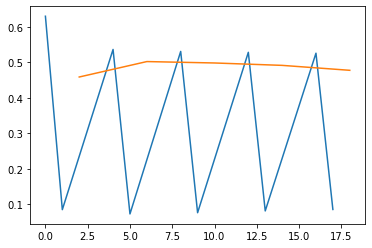

In [ ]:
df["train_loss"].dropna().plot.line(y="train_loss")
df["val_loss"].dropna().plot.line(y="val_loss")


<AxesSubplot:>

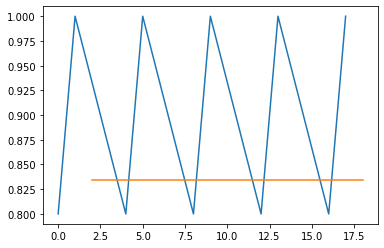

In [ ]:
df["accuracy_step"].dropna().plot.line(y="accuracy_step")
df["val_acc"].dropna().plot.line(y="val_acc")

ValueError: x and y must have same first dimension, but have shapes (6,) and (10,)

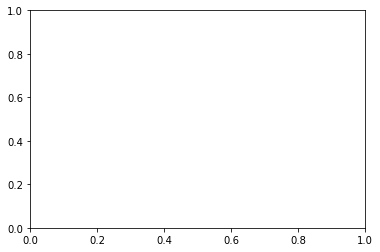

In [ ]:
plt.plot(range(6), df["train_loss"].dropna(), label="train")
plt.plot(range(3), df["val_loss"].dropna(), label="val")
legend = plt.legend(loc='upper right', shadow=True)
plt.title("losses")
plt.xlabel("steps")
plt.ylabel("loss")

In [ ]:
# define any number of nn.Modules (or use your current ones)
encoder = nn.Sequential(nn.Linear(350 * 350*45, 64), nn.ReLU(), nn.Linear(64, 3))
decoder = nn.Sequential(nn.Linear(3, 64), nn.ReLU(), nn.Linear(64, 350 * 350*45))


# define the LightningModule
class LitAutoEncoder(pl.LightningModule):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        # it is independent of forward
        x, y = batch
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        x_hat = self.decoder(z)
        loss = nn.functional.mse_loss(x_hat, x)
        # Logging to TensorBoard (if installed) by default
        self.log("train_loss", loss)
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        return optimizer


# init the autoencoder
autoencoder = LitAutoEncoder(encoder, decoder)